In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import timeit

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
coord.galactocentric_frame_defaults.set('v4.0')
pot = gp.MilkyWayPotential()

matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
matplotlib.rc('axes', labelsize=22) 
matplotlib.rc('legend', fontsize=22)
lable_size = 24

from tqdm import tqdm
from multiprocessing import Pool

import warnings
warnings.filterwarnings("once")

In [6]:
# Import data
cm_vel_all = pd.read_hdf('../data/dr3_near_good_cm_vel_plxzp.h5')
cm_summary_all = pd.read_hdf('../data/dr3_near_good_cm_summary.h5')
orb_param_all = pd.read_hdf('../data/dr3_orb_param_bad_redo_merge.h5')

In [3]:
# Import the data from T. Marchetti 2021
# dat = Table.read('../data/GaiaEDR3_vrad_lowf_vel_0.2_5000_zp.fits', format='fits')
# tm_2021_df = dat.to_pandas()

In [8]:
# Set all -9999 values in APOGEE and RAVE6 cnn [Fe/H] and alpha to np.nan for easier calculation later
ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'m_h_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_err_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'m_h_err_l6s'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_err_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'alpha_m_err_l6s'] = np.nan

# orb_param_all['PCA_X'] = np.empty(len(orb_param_all))*np.nan
# orb_param_all['PCA_Y'] = np.empty(len(orb_param_all))*np.nan

In [4]:
cm_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'best_dataset', 'best_vr',
       'best_vphi', 'best_vz', 'XGC', 'YGC', 'ZGC', 'best_z', 'best_zerr',
       'best_zqul', 'best_U', 'best_V', 'best_W', 'best_Uerr', 'best_Verr',
       'best_Werr', 'best_UVcov', 'best_UWcov', 'best_VWcov',
       'best_v_forder_flag', 'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c',
       'alpha_m_err_r6c', 'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag',
       'bin_flag', 'parallax', 'parallax_error', 'parallax_zpcorr', 'l', 'b',
       'XGCerr', 'YGCerr', 'ZGCerr'],
      dtype='object')

In [51]:
# My selection
metallicity = False
metallicity_add = False
cutoff = 1000
cutoff_l = 4000
cutoff_h = 5000
# Pick the stars with reasonable velocities(need to jutify this later)
# and meet all quality cuts except for the binary cut
# Ignoring the action flags or metallicities for now as they are more of the next step thing to worry about
# Just pick out the stars below a loose zmax cut and make sure they were calculated using Gaia DR2 RV
# for later match with the TM dataset
kin_qual = ((abs(cm_vel_all['best_U']) < 1000) & 
            (abs(cm_vel_all['best_V']) < 1000) & (abs(cm_vel_all['best_W']) < 1000) & 
            (cm_vel_all['qual_flag'] != 2) & (cm_summary_all['GaiaDR2'] > 0.5)
#             (orb_param_all['flag_fail'] == 0) &
#             (orb_param_all['flag_unbound'] == 0) & 
#             (orb_param_all['flag_circ'] == 0) &
#             (orb_param_all['flag_act_conv'] == 0)
           )
feh_qual = (((cm_vel_all['m_h_ap'] > -10.0) | (cm_vel_all['m_h_r6c'] > -10.0) |
             (cm_vel_all['m_h_gl3'] > -10.0) | (cm_vel_all['m_h_l6s'] > -10.0)) &
            ((cm_vel_all['m_h_err_ap'] > 0.0) | (cm_vel_all['m_h_err_r6c'] > 0.0) |
             (cm_vel_all['m_h_err_gl3'] > 0.0) | (cm_vel_all['m_h_err_l6s'] > 0.0)))

# selection = ((abs(orb_param_all['zmax']) > cutoff) & (cm_vel_all['best_vphi'] > 100))
# selection = ((abs(orb_param_all['zmax']) > cutoff) & (cm_vel_all['m_h_mean'] < -1.))
selection = (abs(orb_param_all['zmax']) > cutoff)
# selection = ((abs(orb_param_all['zmax']) > cutoff_l) & (abs(orb_param_all['zmax']) < cutoff_h))

if metallicity == False & metallicity_add == False:
    combined_cut = kin_qual & selection
else:
    print('Applying metallicity quality cut...')
    combined_cut = kin_qual & selection & feh_qual

ind_cut = np.where(combined_cut)[0]
print(len(ind_cut))

688461


In [36]:
# randomly pick 1000 stars from these zamx < 1 kpc stars
# N_star = 1000
# np.random.seed(0)
# ix_rand = np.random.choice(ind_cut,N_star,replace=False)

# Find the 100 stars that were randomly picked for the test between cov and no_cov 
N_star = 100
ix_rand = np.array([np.where(cm_vel_all['source_id'] == df_rd100_cov['source_id'][i])[0][0] for i in range(N_star)])

# Match them with the TM dataset
# Find as many as possible same stars in T. M. 2021 dataset
# mask_list_tm = []

# for i in range(len(ix_rand)):
#     id_tmp = cm_vel_all.loc[ix_rand[i],'source_id']
#     try:
#         mask_list_tm.append(np.where(tm_2021_df['source_id'].values == id_tmp)[0][0])
#     except IndexError:
#         continue

# print('Found',len(mask_list_tm),'matches in T.M. dataset.')

In [11]:
# tm_2021_df_cut = tm_2021_df.loc[mask_list_tm,:]

In [17]:
# orb_param_all.loc[ix_rand[0],'zmax']
cm_vel_all.loc[ix_rand[0],'best_vphi']

-239.7679825249349

In [11]:
cm_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'best_dataset', 'best_vr',
       'best_vphi', 'best_vz', 'XGC', 'YGC', 'ZGC', 'best_z', 'best_zerr',
       'best_zqul', 'best_U', 'best_V', 'best_W', 'best_Uerr', 'best_Verr',
       'best_Werr', 'best_UVcov', 'best_UWcov', 'best_VWcov',
       'best_v_forder_flag', 'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c',
       'alpha_m_err_r6c', 'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag',
       'bin_flag', 'parallax', 'parallax_error', 'parallax_zpcorr', 'l', 'b',
       'XGCerr', 'YGCerr', 'ZGCerr'],
      dtype='object')

In [38]:
# Preextract the numbers in the DataFrame to reduce the overall access number
# source_id_tmp = tm_2021_df_cut.loc[:,'source_id'].values
# XGC_tmp = tm_2021_df_cut.loc[:,'xGC'].values
# YGC_tmp = tm_2021_df_cut.loc[:,'yGC'].values
# ZGC_tmp = tm_2021_df_cut.loc[:,'zGC'].values
# XGC_err_tmp = (tm_2021_df_cut.loc[:,'el_xGC'].values+tm_2021_df_cut.loc[:,'eu_xGC'].values)/2
# YGC_err_tmp = (tm_2021_df_cut.loc[:,'el_yGC'].values+tm_2021_df_cut.loc[:,'eu_yGC'].values)/2
# ZGC_err_tmp = (tm_2021_df_cut.loc[:,'el_zGC'].values+tm_2021_df_cut.loc[:,'eu_zGC'].values)/2
# U_tmp = tm_2021_df_cut.loc[:,'U'].values
# V_tmp = tm_2021_df_cut.loc[:,'V'].values
# W_tmp = tm_2021_df_cut.loc[:,'W'].values
# U_err_tmp = (tm_2021_df_cut.loc[:,'el_U'].values+tm_2021_df_cut.loc[:,'eu_U'].values)/2
# V_err_tmp = (tm_2021_df_cut.loc[:,'el_V'].values+tm_2021_df_cut.loc[:,'eu_V'].values)/2
# W_err_tmp = (tm_2021_df_cut.loc[:,'el_W'].values+tm_2021_df_cut.loc[:,'eu_W'].values)/2

source_id_tmp = cm_vel_all.loc[ix_rand,'source_id'].values
XGC_tmp = cm_vel_all.loc[ix_rand,'XGC'].values
YGC_tmp = cm_vel_all.loc[ix_rand,'YGC'].values
ZGC_tmp = cm_vel_all.loc[ix_rand,'ZGC'].values
XGC_err_tmp = cm_vel_all.loc[ix_rand,'XGCerr'].values
YGC_err_tmp = cm_vel_all.loc[ix_rand,'YGCerr'].values
ZGC_err_tmp = cm_vel_all.loc[ix_rand,'ZGCerr'].values
U_tmp = cm_vel_all.loc[ix_rand,'best_U'].values
V_tmp = cm_vel_all.loc[ix_rand,'best_V'].values
W_tmp = cm_vel_all.loc[ix_rand,'best_W'].values
U_err_tmp = cm_vel_all.loc[ix_rand,'best_Uerr'].values
V_err_tmp = cm_vel_all.loc[ix_rand,'best_Verr'].values
W_err_tmp = cm_vel_all.loc[ix_rand,'best_Werr'].values


In [18]:
def int_orbit(i):
    if np.isnan(XGC_tmp[i]) == True or np.isnan(XGC_err_tmp[i]) == True or np.isnan(U_err_tmp[i]) == True or np.isnan(U_tmp[i]) == True:
        return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    
    XGC = XGC_tmp[i]
    YGC = YGC_tmp[i]
    ZGC = ZGC_tmp[i]
    XGC_err = XGC_err_tmp[i]
    YGC_err = YGC_err_tmp[i]
    ZGC_err = ZGC_err_tmp[i]
    U = U_tmp[i]
    V = V_tmp[i]
    W = W_tmp[i]
    U_err = U_err_tmp[i]
    V_err = V_err_tmp[i]
    W_err = W_err_tmp[i]
    
    samples_mean = coord.SkyCoord(x=XGC*u.pc, y=YGC*u.pc,z=ZGC*u.pc,
    v_x=U*u.km/u.second,v_y=V*u.km/u.second,v_z=W*u.km/u.second,frame=coord.Galactocentric)
    
    samples_err = coord.SkyCoord(x=XGC_err*u.pc, y=YGC_err*u.pc,z=ZGC_err*u.pc,
    v_x=U_err*u.km/u.second,v_y=V_err*u.km/u.second,v_z=W_err*u.km/u.second,frame=coord.Galactocentric)
    
    XGC_samp = np.random.normal(samples_mean.x.value, samples_err.x.value,
                                N_samp) * samples_mean.x.unit
    YGC_samp = np.random.normal(samples_mean.y.value, samples_err.y.value,
                                N_samp) * samples_mean.y.unit
    ZGC_samp = np.random.normal(samples_mean.z.value, samples_err.z.value,
                                N_samp) * samples_mean.z.unit
    U_samp = np.random.normal(samples_mean.v_x.value, samples_err.v_x.value,
                              N_samp) * samples_mean.v_x.unit
    V_samp = np.random.normal(samples_mean.v_y.value, samples_err.v_y.value,
                              N_samp) * samples_mean.v_y.unit
    W_samp = np.random.normal(samples_mean.v_z.value, samples_err.v_z.value,
                              N_samp) * samples_mean.v_z.unit
    
    samples = coord.SkyCoord(x=XGC_samp, y=YGC_samp,z=ZGC_samp,
    v_x=U_samp,v_y=V_samp,v_z=W_samp,frame=coord.Galactocentric)

    
    # Integrate the orbit
    w0_samples = gd.PhaseSpacePosition(samples.data)
    orbit_samples = gp.hamiltonian.Hamiltonian(pot).integrate_orbit(w0_samples, dt=-1*u.Myr, n_steps=10000)
    
    
    start_time = timeit.default_timer()
    # Obtain the orbital properties
    E_samp = orbit_samples.energy().to_value(u.km**2/u.second**2)[0]
    KE_samp = orbit_samples.kinetic_energy().to_value(u.km**2/u.second**2)[0]
    PE_samp = orbit_samples.potential_energy().to_value(u.km**2/u.second**2)[0]
    Lx_samp = orbit_samples.angular_momentum()[0].to_value(u.km*u.kpc/u.second)[0]
    Ly_samp = orbit_samples.angular_momentum()[1].to_value(u.km*u.kpc/u.second)[0]
    Lz_samp = orbit_samples.angular_momentum()[2].to_value(u.km*u.kpc/u.second)[0]
    ecc_samp = orbit_samples.eccentricity().value
    zmax_samp = orbit_samples.zmax().to_value(u.pc)
    apo_samp = orbit_samples.apocenter().to_value(u.pc)
    peri_samp = orbit_samples.pericenter().to_value(u.pc)
    
    E, E_err = np.mean(E_samp), np.std(E_samp)
    KE, KE_err = np.mean(KE_samp), np.std(KE_samp)
    PE, PE_err = np.mean(PE_samp), np.std(PE_samp)
    Lx, Lx_err = np.mean(Lx_samp), np.std(Lx_samp)
    Ly, Ly_err = np.mean(Ly_samp), np.std(Ly_samp)
    Lz, Lz_err = np.mean(Lz_samp), np.std(Lz_samp)
    ecc, ecc_err = np.mean(ecc_samp), np.std(ecc_samp)
    zmax, zmax_err = np.mean(zmax_samp), np.std(zmax_samp)
    apo, apo_err = np.mean(apo_samp), np.std(apo_samp)
    peri, peri_err = np.mean(peri_samp), np.std(peri_samp)
    
    
    # Select only the first 10 orbit sampls for action calculation
    orbit_samples = orbit_samples[:,:10]
    
    # Perform all flag check on an "all" basis
    # i.e. a 1 flag means at least one of the orbit sample
    # Check if the circulation axis is z
    # Flag the result if it's not
    if orbit_samples.circulation()[0].all() == 0 and orbit_samples.circulation()[1].all() == 0 and orbit_samples.circulation()[2].all() == 1:
        flag_circ = 0
    else:
        flag_circ = 1
    
    flag_fail = 0
    
    JR_samp, Jphi_samp, Jz_samp = np.empty(10), np.empty(10), np.empty(10)
    
    # Obtain the action-angle space properties
    for j in range(10):
        # Use the gala function for finding actions in batches
        try:
            aaf = gd.find_actions(orbit_sample,N_max=8)
            JR_samp[j],Jphi_samp[j],Jz_samp[j] = aaf['actions'][0].to_value(u.km/u.s*u.kpc), aaf['actions'][1].to_value(u.km/u.s*u.kpc), aaf['actions'][2].to_value(u.km/u.s*u.kpc)
        except:
            flag_fail = 1
            JR_samp[j],Jphi_samp[j],Jz_samp[j] = np.nan, np.nan, np.nan
        
    JR, JR_err = np.nanmean(JR_samp), np.nanstd(JR_samp)
    Jphi, Jphi_err = np.nanmean(Jphi_samp), np.nanstd(Jphi_samp)
    Jz, Jz_err = np.nanmean(Jz_samp), np.nanstd(Jz_samp)
    
    return [E, KE, PE, Lx, Ly, Lz, ecc, zmax, apo, 
            peri, JR, Jphi, Jz, E_err, KE_err, PE_err, Lx_err, Ly_err, 
            Lz_err, ecc_err, zmax_err, apo_err, peri_err, JR_err, Jphi_err, Jz_err, flag_circ, flag_fail]

In [ ]:
# Do checkpoints every 100 stars
cp_every = 100
N_cp = int(N_star/cp_every)

# Delete the extracted columns
# del(tm_2021_df_cut)

# Create the new dataframe for outputing checkpoints
output_df = pd.DataFrame({'source_id': [np.nan]*cp_every, 'Etot': [np.nan]*cp_every, 'KE': [np.nan]*cp_every, 'PE': [np.nan]*cp_every,
'Lx': [np.nan]*cp_every, 'Ly': [np.nan]*cp_every, 'Lz': [np.nan]*cp_every, 'ecc': [np.nan]*cp_every, 'zmax': [np.nan]*cp_every,
'apo': [np.nan]*cp_every, 'peri': [np.nan]*cp_every,'JR': [np.nan]*cp_every,'Jphi': [np.nan]*cp_every,'Jz': [np.nan]*cp_every, 'e_Etot': [np.nan]*cp_every, 'e_KE': [np.nan]*cp_every, 'e_PE': [np.nan]*cp_every,
'e_Lx': [np.nan]*cp_every, 'e_Ly': [np.nan]*cp_every, 'e_Lz': [np.nan]*cp_every, 'e_ecc': [np.nan]*cp_every, 'e_zmax': [np.nan]*cp_every,
'e_apo': [np.nan]*cp_every, 'e_peri': [np.nan]*cp_every, 'e_JR': [np.nan]*cp_every,'e_Jphi': [np.nan]*cp_every,'e_Jz': [np.nan]*cp_every,
'flag_circ': [np.nan]*cp_every,'flag_fail': [np.nan]*cp_every})

# set up a pool of workers
print('Setting up the pool workers now!')
pool = Pool(3)

# Loop through cp_every stars and then checkpoint
for i in range(N_cp+1):
    print('Starting orbit integration (pool) for Checkpoint',i)
    # Determine if we are at the last checkpoint with fewer than cp_every stars left
    if i == N_cp:
        inp = range(i*cp_every,N_star)
        cp_last = N_star - i*cp_every
        output_df = pd.DataFrame({'source_id': [np.nan]*cp_every, 'Etot': [np.nan]*cp_every, 'KE': [np.nan]*cp_every, 'PE': [np.nan]*cp_every,
'Lx': [np.nan]*cp_every, 'Ly': [np.nan]*cp_every, 'Lz': [np.nan]*cp_every, 'ecc': [np.nan]*cp_every, 'zmax': [np.nan]*cp_every,
'apo': [np.nan]*cp_every, 'peri': [np.nan]*cp_every,'JR': [np.nan]*cp_every,'Jphi': [np.nan]*cp_every,'Jz': [np.nan]*cp_every, 'e_Etot': [np.nan]*cp_every, 'e_KE': [np.nan]*cp_every, 'e_PE': [np.nan]*cp_every,
'e_Lx': [np.nan]*cp_every, 'e_Ly': [np.nan]*cp_every, 'e_Lz': [np.nan]*cp_every, 'e_ecc': [np.nan]*cp_every, 'e_zmax': [np.nan]*cp_every,
'e_apo': [np.nan]*cp_every, 'e_peri': [np.nan]*cp_every, 'e_JR': [np.nan]*cp_every,'e_Jphi': [np.nan]*cp_every,'e_Jz': [np.nan]*cp_every,
'flag_circ': [np.nan]*cp_every,'flag_fail': [np.nan]*cp_every})
    else:
        inp = range(i*cp_every,(i+1)*cp_every)
    
    # Determine if there's actually no stars at the last checkpoint
    # which is the case if N_star is integer multiple of cp_every
    if len(inp) == 0:
            break
    
    res = pool.map(int_orbit, inp)

    res = np.array(list(zip(*res)))
    print("Finished pool! Adding data to the dataframe and writing out checkpoint",i)
#     print(res)

    # Store the orbital properties
    output_df['source_id'] = source_id_tmp[inp]
    output_df['Etot'] = res[0]
    output_df['KE'] = res[1]
    output_df['PE'] = res[2]
    output_df['Lx'] = res[3]
    output_df['Ly'] = res[4]
    output_df['Lz'] = res[5]
    output_df['ecc'] = res[6]
    output_df['zmax'] = res[7]
    output_df['apo'] = res[8]
    output_df['peri'] = res[9]
    output_df['JR'] = res[10]
    output_df['Jphi'] = res[11]
    output_df['Jz'] = res[12]
    output_df['e_Etot'] = res[13]
    output_df['e_KE'] = res[14]
    output_df['e_PE'] = res[15]
    output_df['e_Lx'] = res[16]
    output_df['e_Ly'] = res[17]
    output_df['e_Lz'] = res[18]
    output_df['e_ecc'] = res[19]
    output_df['e_zmax'] = res[20]
    output_df['e_apo'] = res[21]
    output_df['e_peri'] = res[22]
    output_df['e_JR'] = res[23]
    output_df['e_Jphi'] = res[24]
    output_df['e_Jz'] = res[25]
    output_df['flag_circ'] = res[26]
    output_df['flag_fail'] = res[27]
    

    # output result
    # run only once
    print('Outputting the orbital properties checkpoint',i)
    output_path = './orb_param_err_test_checkpoint_' + str(i) + '_1108.csv'
    start_time_w = timeit.default_timer()
    output_df.to_csv(output_path,index=False)
    elapsed_w = timeit.default_timer() - start_time_w
    print('Time took to write results:',elapsed_w,"seconds.")

# Close the pool
pool.close()
pool.join()

/opt/anaconda3/lib/python3.7/site-packages/gala/dynamics/actionangle.py:538: UserWarning: More unknowns than equations!
  warnings.warn("More unknowns than equations!")
/opt/anaconda3/lib/python3.7/site-packages/gala/dynamics/actionangle.py:538: UserWarning: More unknowns than equations!
  warnings.warn("More unknowns than equations!")
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [39]:
# Integrate orbits for these 1000 stars with error sampling
# To expedite the process, don't do action calculation for now
N_samp = 100

# Set the file name to store the result

# for i in range(N_star):
for i in range(1):
    XGC = XGC_tmp[i]
    YGC = YGC_tmp[i]
    ZGC = ZGC_tmp[i]
    XGC_err = XGC_err_tmp[i]
    YGC_err = YGC_err_tmp[i]
    ZGC_err = ZGC_err_tmp[i]
    U = U_tmp[i]
    V = V_tmp[i]
    W = W_tmp[i]
    U_err = U_err_tmp[i]
    V_err = V_err_tmp[i]
    W_err = W_err_tmp[i]
    
    samples_mean = coord.SkyCoord(x=XGC*u.pc, y=YGC*u.pc,z=ZGC*u.pc,
    v_x=U*u.km/u.second,v_y=V*u.km/u.second,v_z=W*u.km/u.second,frame=coord.Galactocentric)
    
    samples_err = coord.SkyCoord(x=XGC_err*u.pc, y=YGC_err*u.pc,z=ZGC_err*u.pc,
    v_x=U_err*u.km/u.second,v_y=V_err*u.km/u.second,v_z=W_err*u.km/u.second,frame=coord.Galactocentric)
    
    XGC_samp = np.random.normal(samples_mean.x.value, samples_err.x.value,
                                N_samp) * samples_mean.x.unit
    YGC_samp = np.random.normal(samples_mean.y.value, samples_err.y.value,
                                N_samp) * samples_mean.y.unit
    ZGC_samp = np.random.normal(samples_mean.z.value, samples_err.z.value,
                                N_samp) * samples_mean.z.unit
    U_samp = np.random.normal(samples_mean.v_x.value, samples_err.v_x.value,
                              N_samp) * samples_mean.v_x.unit
    V_samp = np.random.normal(samples_mean.v_y.value, samples_err.v_y.value,
                              N_samp) * samples_mean.v_y.unit
    W_samp = np.random.normal(samples_mean.v_z.value, samples_err.v_z.value,
                              N_samp) * samples_mean.v_z.unit
    
    samples = coord.SkyCoord(x=XGC_samp, y=YGC_samp,z=ZGC_samp,
    v_x=U_samp,v_y=V_samp,v_z=W_samp,frame=coord.Galactocentric)

    
    # Integrate the orbit
    w0_samples = gd.PhaseSpacePosition(samples.data)
    print("Check to see if the Hamiltonian is .c_enabled",gp.hamiltonian.Hamiltonian(pot).c_enabled)
    orbit_samples = gp.hamiltonian.Hamiltonian(pot).integrate_orbit(w0_samples, dt=-1*u.Myr, n_steps=10000)
    
    
    start_time = timeit.default_timer()
    # Obtain the orbital properties
    E_samp = orbit_samples.energy().to_value(u.km**2/u.second**2)[0]
    KE_samp = orbit_samples.kinetic_energy().to_value(u.km**2/u.second**2)[0]
    PE_samp = orbit_samples.potential_energy().to_value(u.km**2/u.second**2)[0]
    Lx_samp = orbit_samples.angular_momentum()[0].to_value(u.km*u.kpc/u.second)[0]
    Ly_samp = orbit_samples.angular_momentum()[1].to_value(u.km*u.kpc/u.second)[0]
    Lz_samp = orbit_samples.angular_momentum()[2].to_value(u.km*u.kpc/u.second)[0]
    ecc_samp = orbit_samples.eccentricity().value
    zmax_samp = orbit_samples.zmax().to_value(u.pc)
    apo_samp = orbit_samples.apocenter().to_value(u.pc)
    peri_samp = orbit_samples.pericenter().to_value(u.pc)
    
    E, E_err = np.mean(E_samp), np.std(E_samp)
    KE, KE_err = np.mean(KE_samp), np.std(KE_samp)
    PE, PE_err = np.mean(PE_samp), np.std(PE_samp)
    Lx, Lx_err = np.mean(Lx_samp), np.std(Lx_samp)
    Ly, Ly_err = np.mean(Ly_samp), np.std(Ly_samp)
    Lz, Lz_err = np.mean(Lz_samp), np.std(Lz_samp)
    ecc, ecc_err = np.mean(ecc_samp), np.std(ecc_samp)
    zmax, zmax_err = np.mean(zmax_samp), np.std(zmax_samp)
    apo, apo_err = np.mean(apo_samp), np.std(apo_samp)
    peri, peri_err = np.mean(peri_samp), np.std(peri_samp)
    
    # Select only the first 10 orbit sampls for action calculation
    orbit_samples = orbit_samples[:,:10]
    
    # Perform all flag check on an "all" basis
    # i.e. a 1 flag means at least one of the orbit sample
    # Check if the circulation axis is z
    # Flag the result if it's not
    if orbit_samples.circulation()[0].all() == 0 and orbit_samples.circulation()[1].all() == 0 and orbit_samples.circulation()[2].all() == 1:
        flag_circ = 0
    else:
        flag_circ = 1
    
    flag_fail = 0
#     flag_unbound = 0
#     flag_act_conv = 0
    
    JR_samp, Jphi_samp, Jz_samp = np.empty(10), np.empty(10), np.empty(10)
    
    # Obtain the action-angle space properties
    for j in range(10):
#         orbit_sample = orbit_samples[:,j]
#         try:
#             toy_potential = gd.fit_isochrone(orbit_sample)
#             try:
#                 result = gd.find_actions(orbit_sample, N_max=8, toy_potential=toy_potential)
#                 JR,Jphi,Jz = result['actions'][0].to_value(u.km/u.s*u.kpc), result['actions'][1].to_value(u.km/u.s*u.kpc), result['actions'][2].to_value(u.km/u.s*u.kpc)
#             except ValueError:
#                 flag_unbound = 1
#                 JR,Jphi,Jz = np.nan, np.nan, np.nan
#         except:
#             flag_fail = 1
#             flag_unbound = np.nan
#             JR,Jphi,Jz = np.nan, np.nan, np.nan
    
        # Try the gala function for finding actions in batches
        try:
            aaf = gd.find_actions(orbit_sample,N_max=8)
            JR_samp[j],Jphi_samp[j],Jz_samp[j] = aaf['actions'][0].to_value(u.km/u.s*u.kpc), aaf['actions'][1].to_value(u.km/u.s*u.kpc), aaf['actions'][2].to_value(u.km/u.s*u.kpc)
        except:
            flag_fail = 1
            JR_samp[j],Jphi_samp[j],Jz_samp[j] = np.nan, np.nan, np.nan
        
        JR, JR_err = np.nanmean(JR_samp), np.nanstd(JR_samp)
        Jphi, Jphi_err = np.nanmean(Jphi_samp), np.nanstd(Jphi_samp)
        Jz, Jz_err = np.nanmean(Jz_samp), np.nanstd(Jz_samp)
        
        # Check convergence on action and flag if not converged to within 5%
#         if abs(Jphi-Lz)/abs(Lz) > 0.05:
#             flag_act_conv = 1
        
    
#   The time related functions act strangely within pool... leave it for now
    if i % 1 == 0:
        elapsed = timeit.default_timer() - start_time
        print("Orbital parameters evaluated up to star", i,"in",elapsed,"seconds.")
        
    


/opt/anaconda3/lib/python3.7/site-packages/gala/dynamics/actionangle.py:538: UserWarning: More unknowns than equations!
  warnings.warn("More unknowns than equations!")


Orbital parameters evaluated up to star 0 in 40.477879015990766 seconds.


In [45]:
print("Check to see if the Hamiltonian is .c_enabled",gp.hamiltonian.Hamiltonian(pot).c_enabled)

Check to see if the Hamiltonian is .c_enabled True


In [41]:
print([E, KE, PE, Lx, Ly, Lz, ecc, zmax, apo, peri, JR, Jphi, Jz, E_err, KE_err, PE_err, 
            Lx_err, Ly_err, Lz_err, ecc_err, zmax_err, apo_err, peri_err,
            JR_err, Jphi_err, Jz_err, flag_circ, flag_fail])
print(df_rd100_no_cov.loc[0,:])
print(df_rd100_cov.loc[0,:])

[-122821.8882303816, 32966.763309509246, -155788.65153989085, 4.574164185869674, 21.506714590060223, -2047.9381114082926, 0.21079335543251632, 43.83604112586639, 11223.191343813942, 7315.373040766773, 1.2403810854306356, -1703.4556773545671, 0.33652091221885916, 32.512549507243556, 32.45112339398304, 1.0962804071582117, 0.02141255649888774, 1.5662802485297054, 0.5952205204291119, 0.0012323565853248578, 2.517191815320013, 17.72393102722807, 7.88331540711954, 0.0, 2.2737367544323206e-13, 0.0, 0, 0]
source_id    6.561474e+16
Etot        -1.228246e+05
KE           3.296403e+04
PE          -1.557886e+05
Lx           4.569462e+00
Ly           2.145671e+01
Lz          -2.047959e+03
ecc          2.106442e-01
zmax         4.374168e+01
apo          1.122128e+04
peri         7.316413e+03
JR                    NaN
Jphi                  NaN
Jz                    NaN
e_Etot       2.748815e+01
e_KE         2.751121e+01
e_PE         1.112002e+00
e_Lx         1.740154e-02
e_Ly         1.439205e+00
e_Lz

In [14]:
# np.shape(orbit_samples[:,0])
result1 = gd.find_actions(orbit_samples[:,0:2],N_max=8)
JR1,Jphi1,Jz1 = result1['actions'][0].to_value(u.km/u.s*u.kpc), result1['actions'][1].to_value(u.km/u.s*u.kpc), result1['actions'][2].to_value(u.km/u.s*u.kpc)
print(JR1,Jphi1,Jz1)

ValueError: could not broadcast input array from shape (3) into shape (2)

In [28]:
mean = (1, 2)
cov = [[1, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, 10)
x[:,1]

array([1.23847334, 1.77717421, 1.43105822, 3.08966326, 1.53248257,
       2.7380454 , 1.49305334, 2.63019476, 1.21496127, 2.9716425 ])

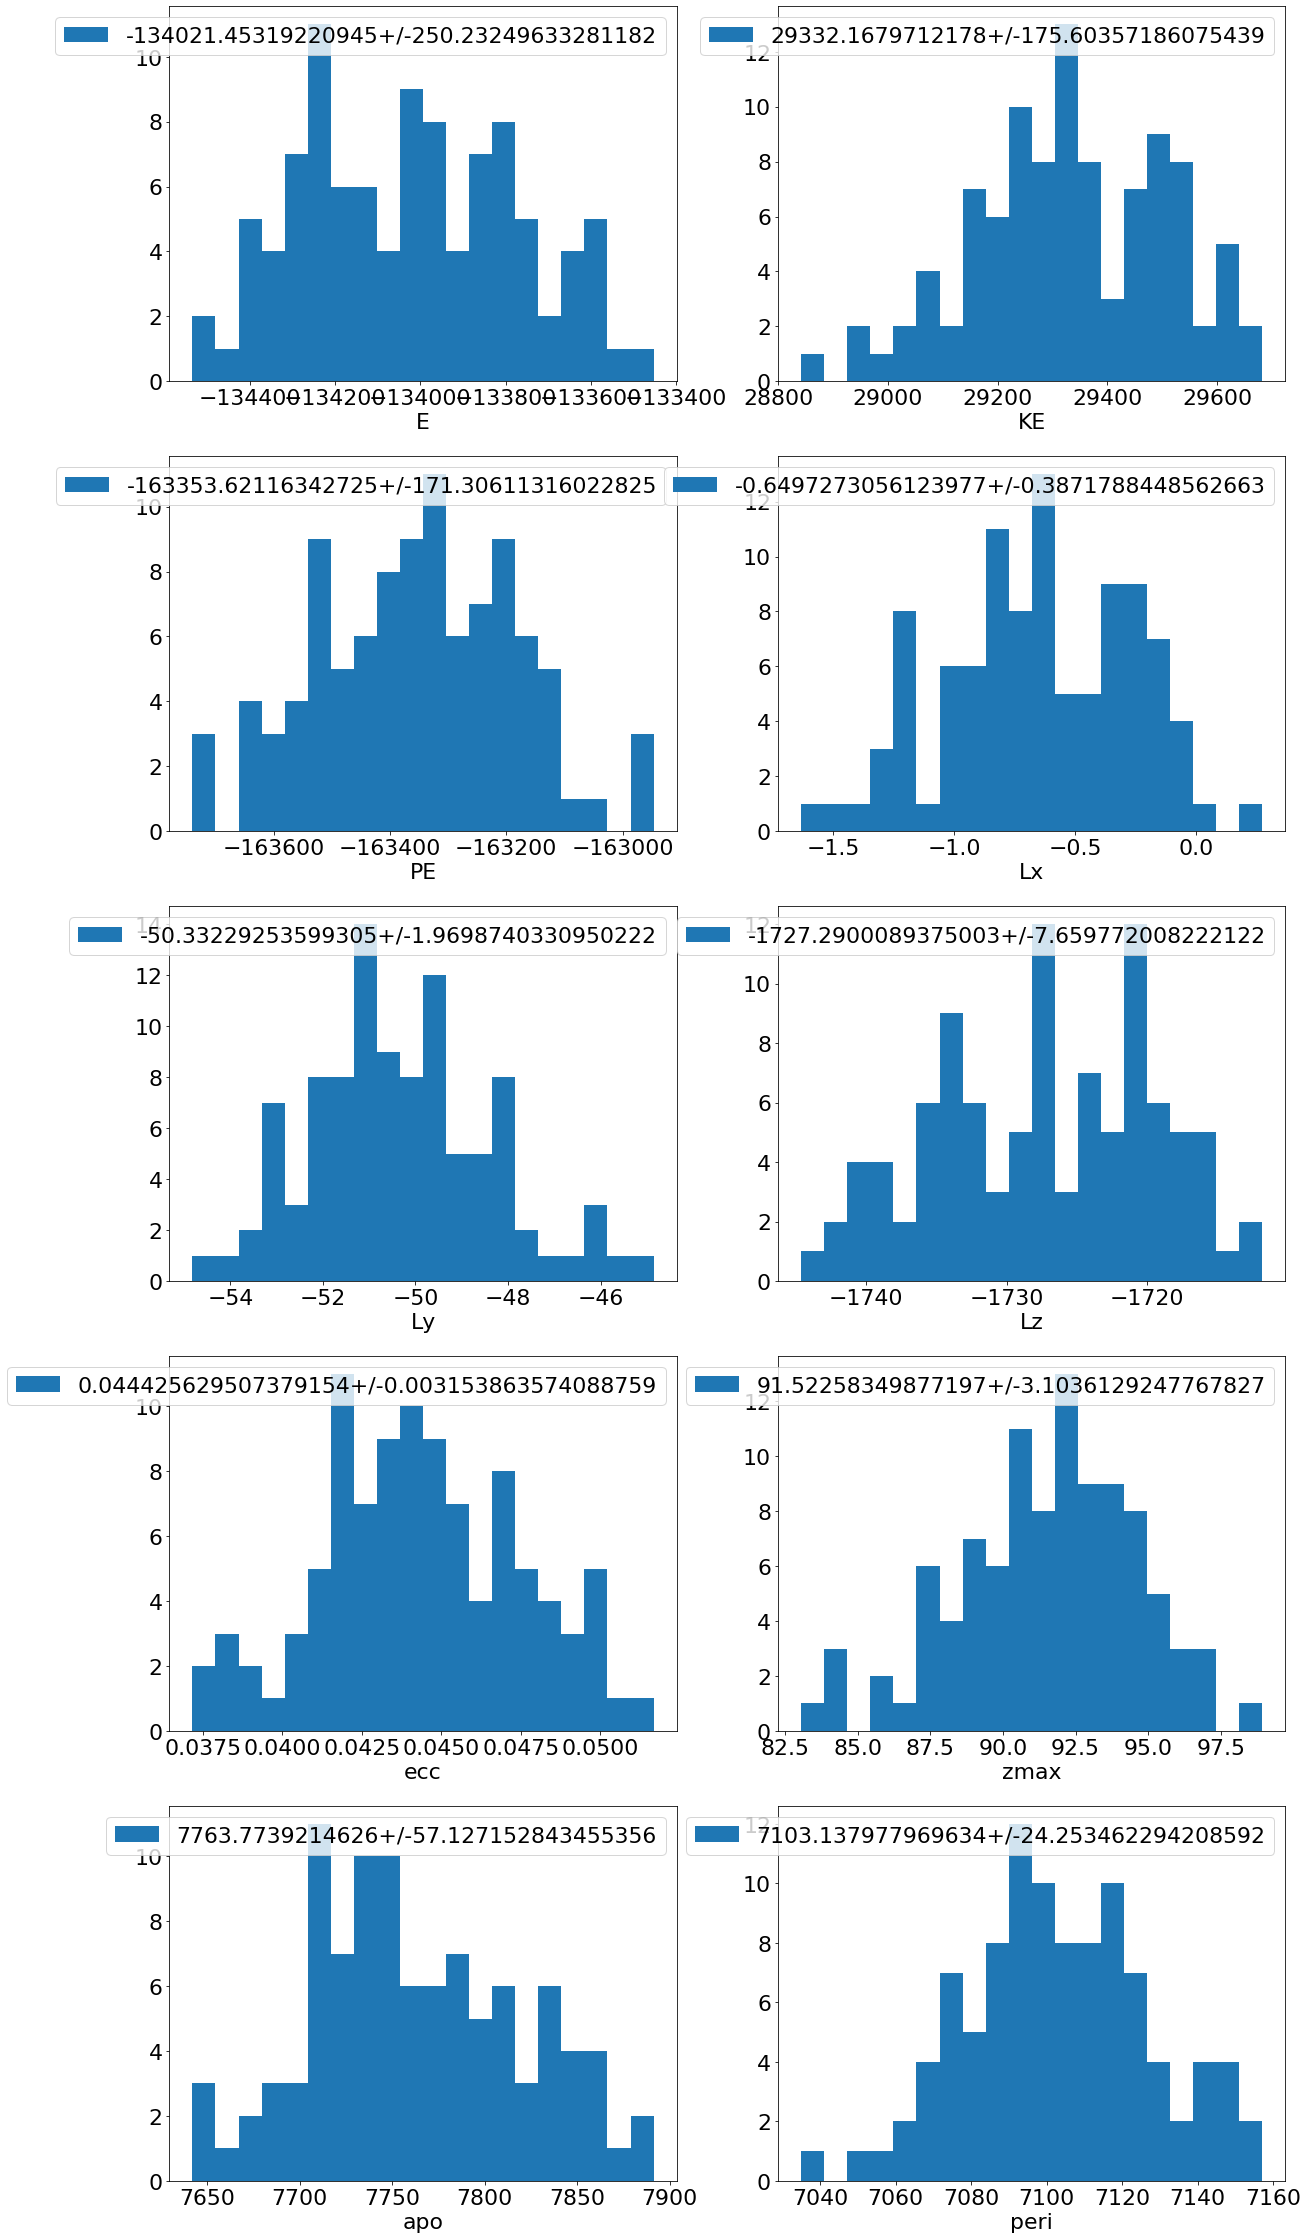

In [38]:
plt.figure(figsize=[20,40])

plt.subplot(5,2,1)
plt.hist(E_samp,bins=20,label=str(E)+'+/-'+str(E_err))
plt.xlabel('E')
plt.legend()

plt.subplot(5,2,2)
plt.hist(KE_samp,bins=20,label=str(KE)+'+/-'+str(KE_err))
plt.xlabel('KE')
plt.legend()

plt.subplot(5,2,3)
plt.hist(PE_samp,bins=20,label=str(PE)+'+/-'+str(PE_err))
plt.xlabel('PE')
plt.legend()

plt.subplot(5,2,4)
plt.hist(Lx_samp,bins=20,label=str(Lx)+'+/-'+str(Lx_err))
plt.xlabel('Lx')
plt.legend()

plt.subplot(5,2,5)
plt.hist(Ly_samp,bins=20,label=str(Ly)+'+/-'+str(Ly_err))
plt.xlabel('Ly')
plt.legend()

plt.subplot(5,2,6)
plt.hist(Lz_samp,bins=20,label=str(Lz)+'+/-'+str(Lz_err))
plt.xlabel('Lz')
plt.legend()

plt.subplot(5,2,7)
plt.hist(ecc_samp,bins=20,label=str(ecc)+'+/-'+str(ecc_err))
plt.xlabel('ecc')
plt.legend()

plt.subplot(5,2,8)
plt.hist(zmax_samp,bins=20,label=str(zmax)+'+/-'+str(zmax_err))
plt.xlabel('zmax')
plt.legend()

plt.subplot(5,2,9)
plt.hist(apo_samp,bins=20,label=str(apo)+'+/-'+str(apo_err))
plt.xlabel('apo')
plt.legend()

plt.subplot(5,2,10)
plt.hist(peri_samp,bins=20,label=str(peri)+'+/-'+str(peri_err))
plt.xlabel('peri')
plt.legend()

plt.show()

In [29]:
# Import the 100 stars used for testing the difference between with and without cavariance in velociites
df_rd100_cov = pd.read_csv('../orb_int_paral_err_g2_only/cov_rd1000_test/orb_param_err_test_checkpoint_0_1111.csv')
df_rd100_no_cov = pd.read_csv('../orb_int_paral_err_g2_only/no_cov_rd1000_test/orb_param_err_test_checkpoint_0_1111.csv')


In [44]:
print(df_rd100_cov.loc[0,:])
df_rd100_cov.head()

source_id    6.561474e+16
Etot        -1.228231e+05
KE           3.296546e+04
PE          -1.557886e+05
Lx           4.569838e+00
Ly           2.167878e+01
Lz          -2.047908e+03
ecc          2.107714e-01
zmax         4.409193e+01
apo          1.122270e+04
peri         7.315400e+03
JR                    NaN
Jphi                  NaN
Jz                    NaN
e_Etot       6.819642e+00
e_KE         6.854809e+00
e_PE         1.112002e+00
e_Lx         1.726790e-02
e_Ly         1.311053e+00
e_Lz         6.201889e-01
e_ecc        8.027377e-04
e_zmax       2.113507e+00
e_apo        7.729333e+00
e_peri       7.401792e+00
e_JR                  NaN
e_Jphi                NaN
e_Jz                  NaN
flag_circ    0.000000e+00
flag_fail    1.000000e+00
Name: 0, dtype: float64


,source_id,Etot,KE,PE,Lx,Ly,Lz,ecc,zmax,apo,...,e_Lz,e_ecc,e_zmax,e_apo,e_peri,e_JR,e_Jphi,e_Jz,flag_circ,flag_fail
0,65614735075397504,-122823.137672,32965.459209,-155788.596881,4.569838,21.678780,-2047.907602,0.210771,44.091926,11222.700573,...,0.620189,0.000803,2.113507,7.729333,7.401792,NaN,NaN,NaN,0.0,1.0
1,188880704491015552,-105170.112866,22621.372947,-127791.485813,8.772567,235.137112,-3000.188656,0.083681,558.916472,14796.345866,...,178.385195,0.012014,66.062345,956.344886,846.007040,NaN,NaN,NaN,0.0,1.0
2,428331629535586176,-135554.014072,19543.766530,-155097.780601,8.240336,212.743263,-1532.082372,0.293983,373.295190,9220.396621,...,13.170869,0.003478,1.416044,41.470493,58.764696,NaN,NaN,NaN,0.0,1.0
3,433826988644606336,-114691.502084,30967.342405,-145658.844488,96.928206,-122.948864,-2347.908779,0.245460,568.680259,13663.701712,...,16.894419,0.005194,23.047963,148.793510,70.685085,NaN,NaN,NaN,0.0,1.0
4,451790908403689344,-118091.310569,27308.733640,-145400.044208,89.924187,11.348206,-2328.732671,0.031652,385.708459,10612.403848,...,12.633981,0.001633,11.392250,71.973451,53.635998,NaN,NaN,NaN,0.0,1.0


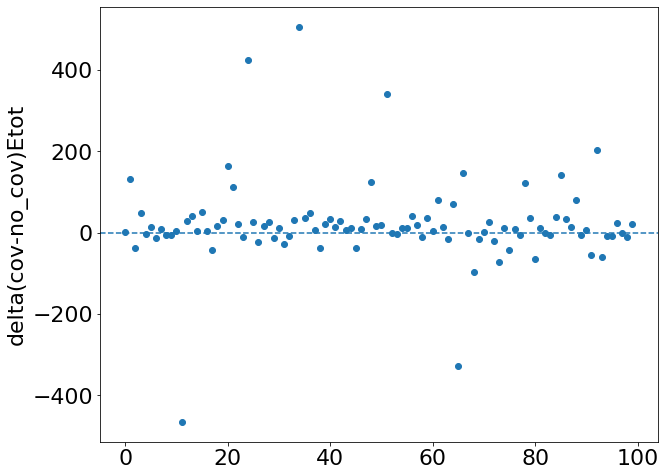

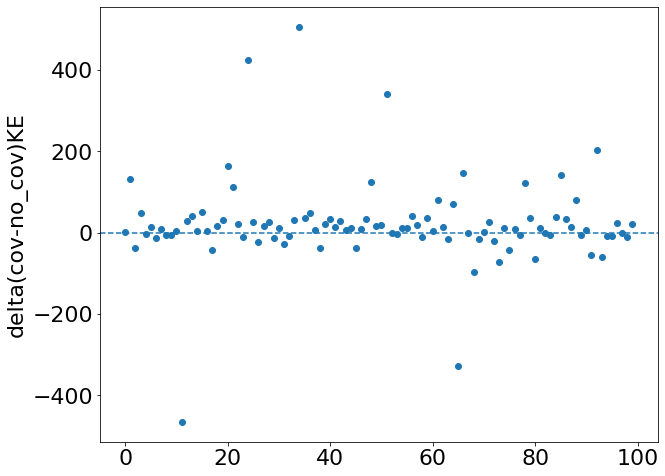

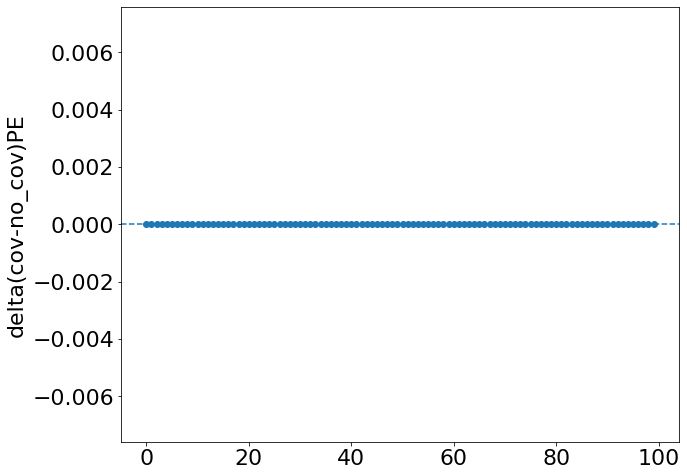

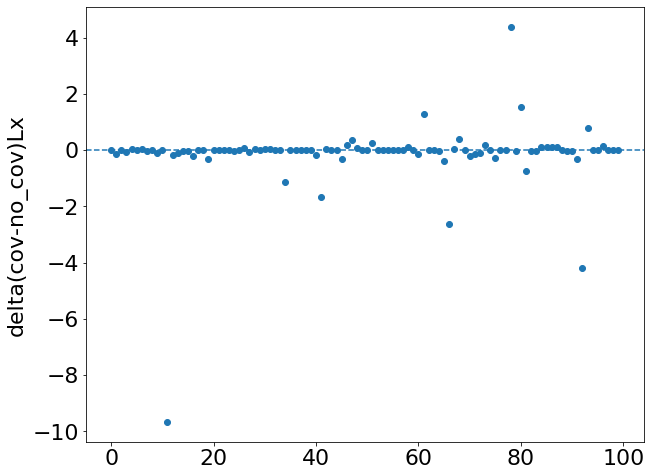

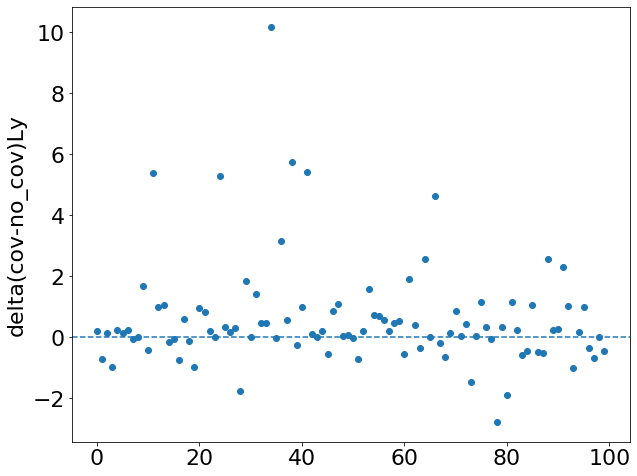

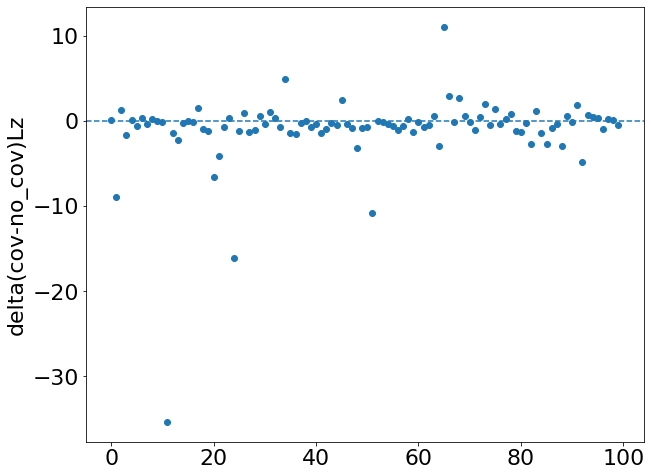

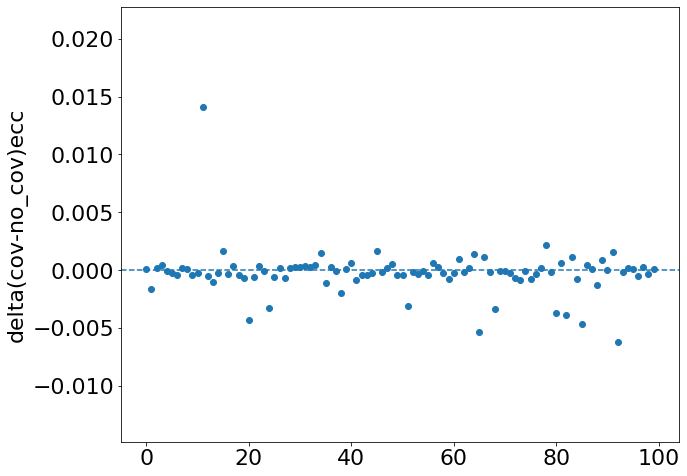

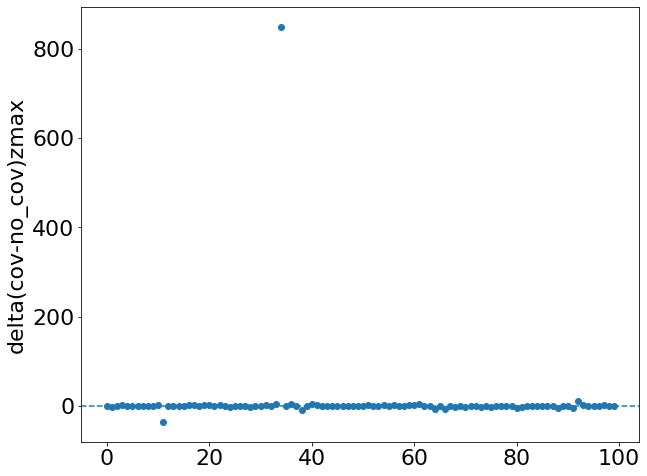

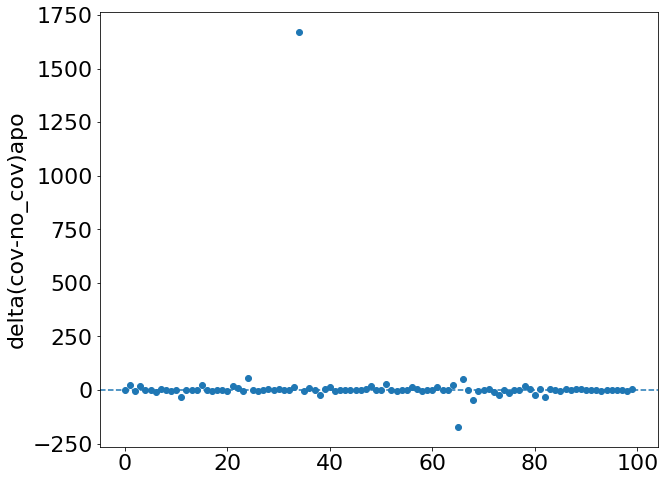

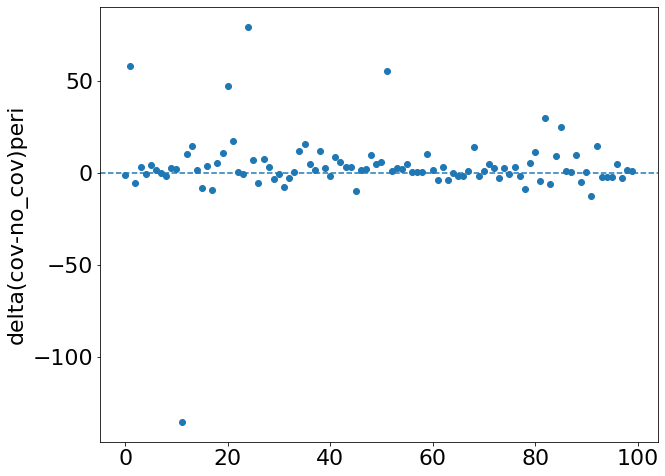

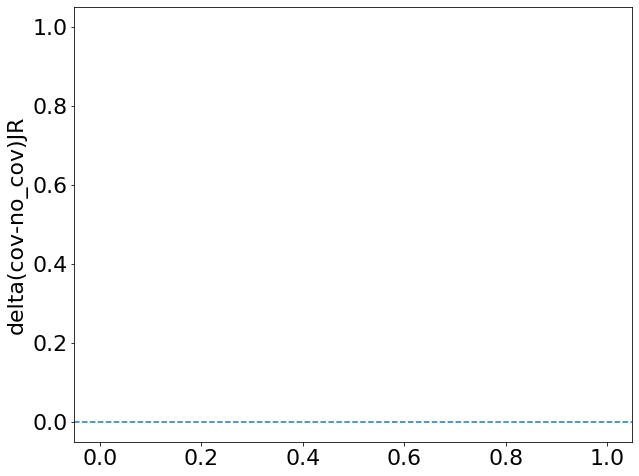

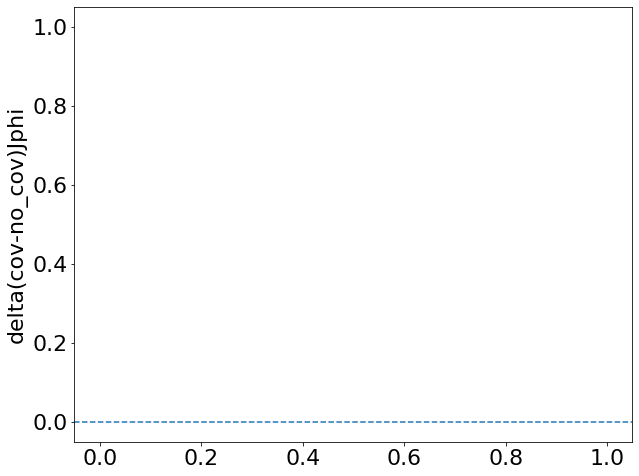

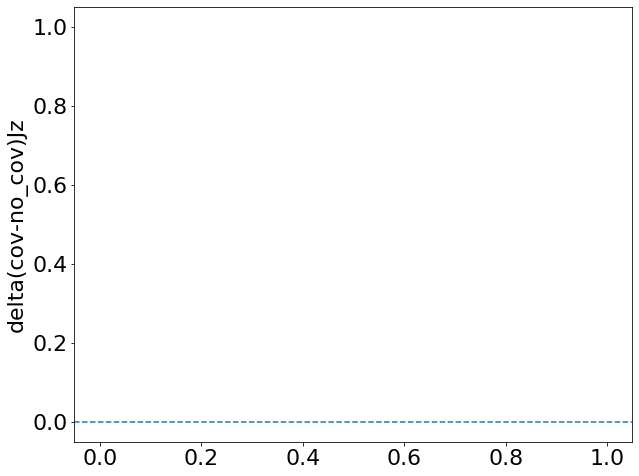

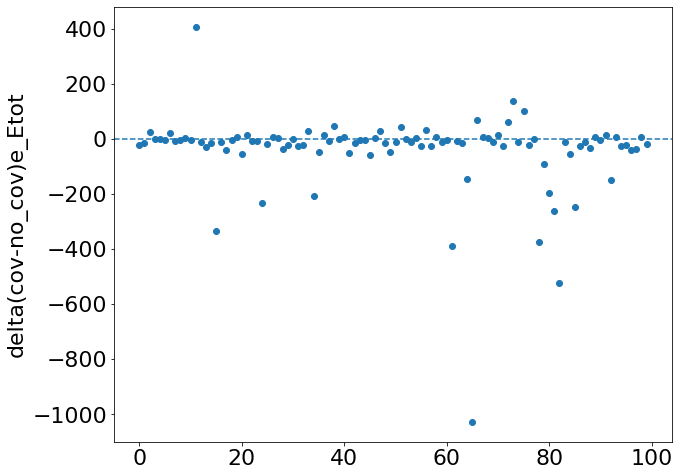

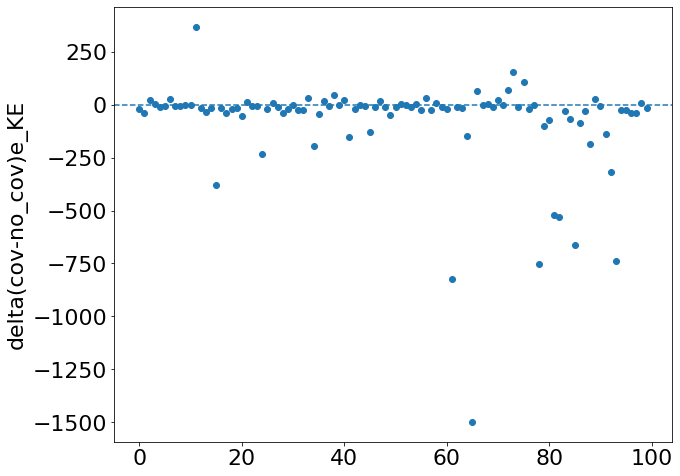

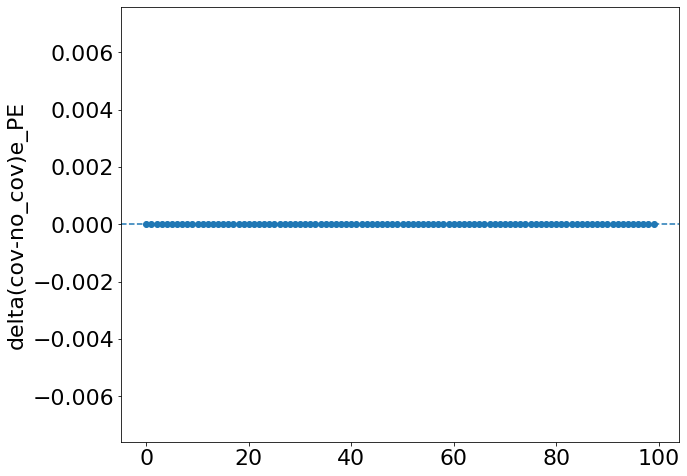

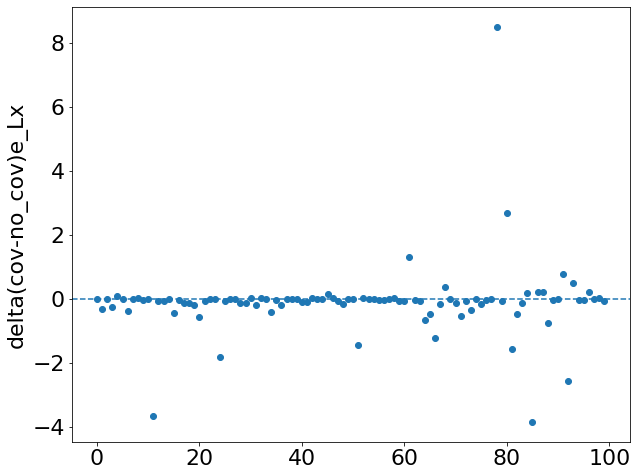

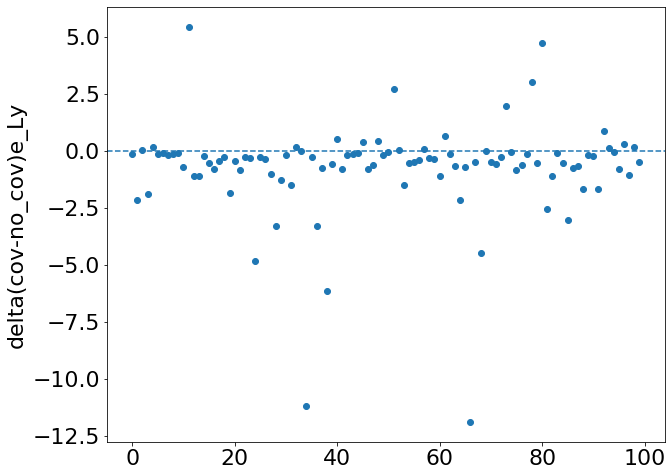

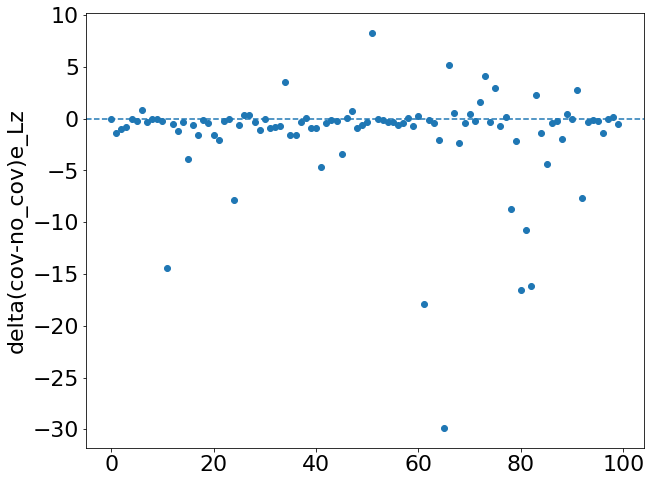

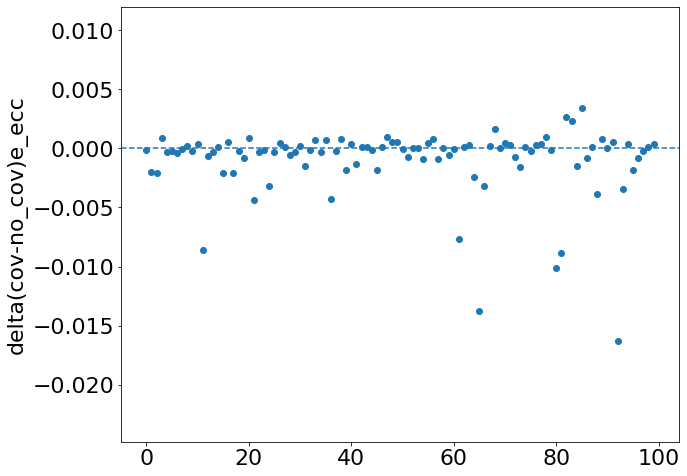

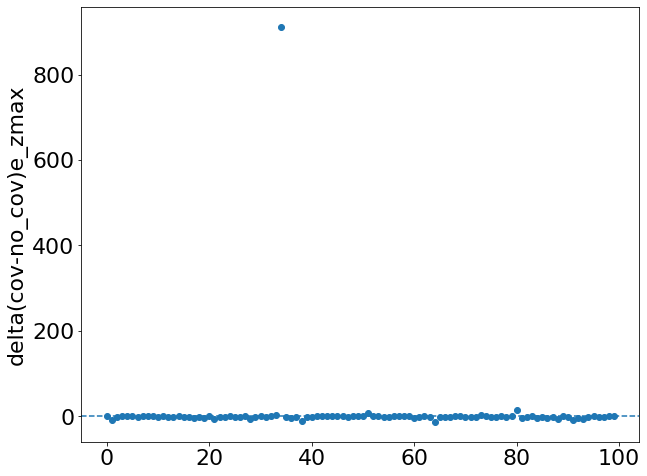

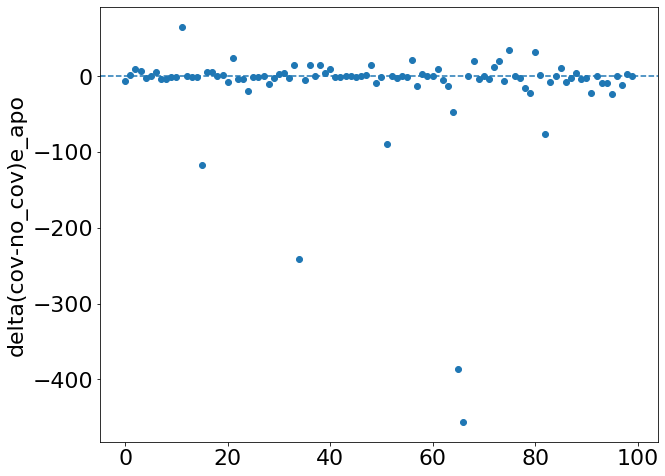

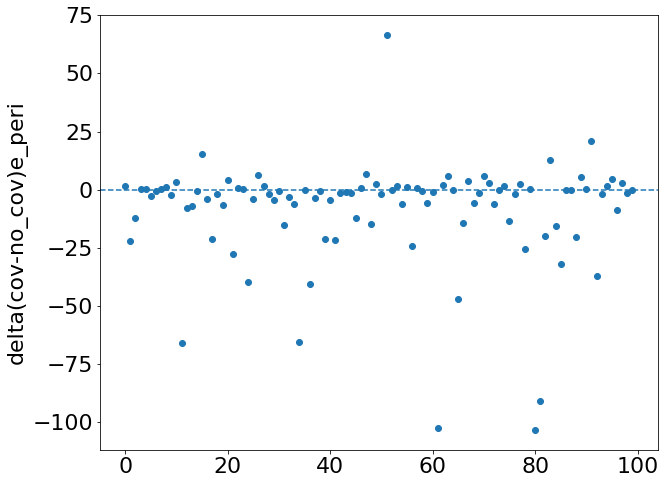

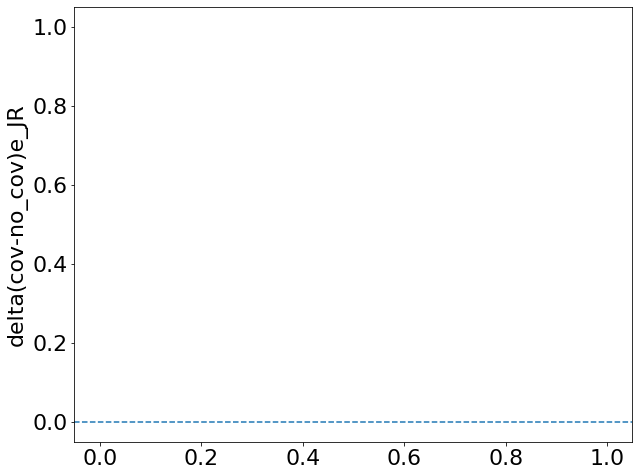

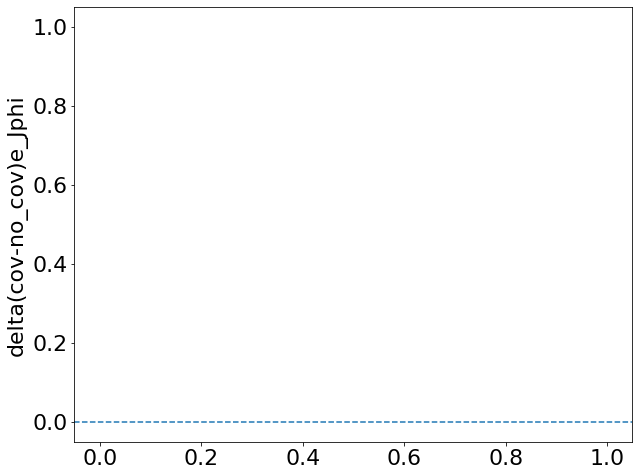

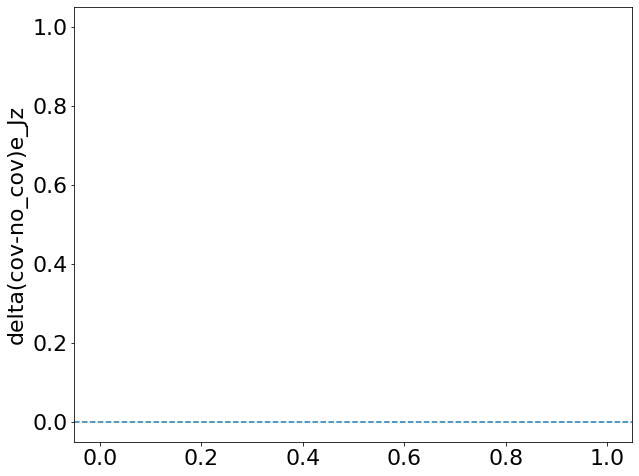

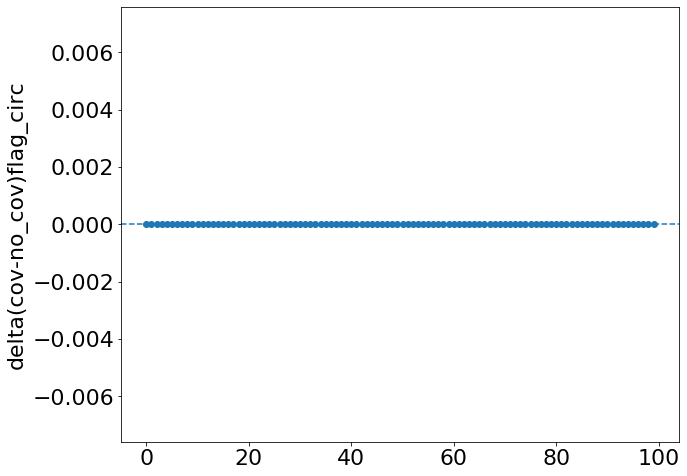

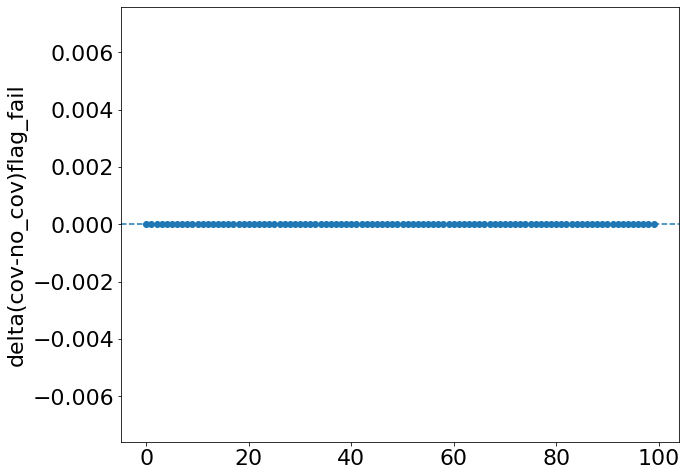

In [34]:
# Compare all columns
for i in range(1,len(df_rd100_cov.columns)):
    col=df_rd100_cov.columns[i]
    
    plt.figure(figsize=[10,8])
    plt.scatter(np.arange(len(df_rd100_cov)),df_rd100_cov[col]-df_rd100_no_cov[col])
    plt.axhline(0,ls='--')
    plt.ylabel('delta(cov-no_cov)'+col)
    plt.show()